In [38]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error,mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
import xgboost as xgb
from sklearn.decomposition import PCA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
from math import sqrt

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PolynomialFeatures, StandardScaler


In [2]:
data = pd.read_csv('energydata_complete.csv')

In [3]:
for num in data['RH_5']:
    try:
        float(num)*0
    except:
        print('Non numerical value found')
        data.loc[data['RH_5']==num,'RH_5']=None

Non numerical value found


In [4]:
data['date']=pd.to_datetime(data['date'])
data['RH_5']=pd.to_numeric(data['RH_5'])

In [5]:
data2 = data.copy()
data2 = data2.set_index('date')
data2 = data2.sort_index(ascending=True)

In [6]:
def find_outliers(df):
    df2 = df.copy()
    cols = list(df.columns)
    cols.remove('Energy kWh')
#     print(cols)
    outlier_df = pd.DataFrame()
    clean_df = pd.DataFrame()
    df2['outlier']=''
    df2['column_value'] = ''
    for col in cols:
        q3 = np.quantile(df2[col],0.9)
        q1 = np.quantile(df2[col],0.1)
        iqr = q3-q1

        lower_range = q1 - (iqr*1.5)
        upper_range = q3 + (iqr*1.5)
        
        df2.loc[(df2[col]<lower_range)|(df2[col]>upper_range),['outlier','column_value']] = 'yes',col
        
    outlier_df = df2.loc[df2['outlier']=='yes']
    clean_df = df2.loc[df2['outlier']!='yes']
    clean_df = clean_df.loc[(clean_df['Energy kWh']<1000)]
        
    print('outlier_df:',outlier_df.shape)
    print('clean_df:',clean_df.shape)

    return outlier_df,clean_df

In [7]:
outlier_df,clean_df = find_outliers(data2)

outlier_df: (23, 27)
clean_df: (19706, 27)


In [8]:
data3 = clean_df.copy().reset_index()

data3['month']=data3.date.dt.month
data3['day']=data3.date.dt.day
data3['year']=data3.date.dt.year
data3['hour']=data3.date.dt.hour
data3['minute']=data3.date.dt.minute
data3['hours_in_minutes'] = (data3['hour']*60)+(data3['minute'])

Pearson correlation coefficient: 0.21724975308554234


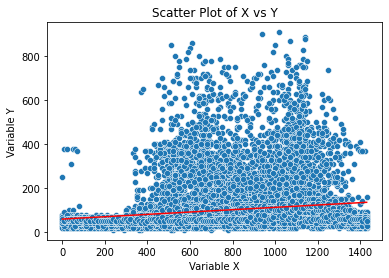

In [9]:
from scipy.stats import pearsonr
corr, _ = pearsonr(data3['hours_in_minutes'], data3['Energy kWh'])
print("Pearson correlation coefficient:", corr)

# Create a scatter plot with a fitted regression line
sns.scatterplot(data=data3,x='hours_in_minutes',y='Energy kWh')
plt.xlabel('Variable X')
plt.ylabel('Variable Y')
plt.title('Scatter Plot of X vs Y')

# Add a fitted regression line
m, b = np.polyfit(data3['hours_in_minutes'], data3['Energy kWh'], 1)  # Fit a linear regression line
plt.plot(data3['hours_in_minutes'], m * data3['hours_in_minutes'] + b, color='red')

plt.show()

In [10]:
X = data3.drop('Energy kWh',axis=1)
y = data3['Energy kWh']

dummy_values = sorted(X['month'].unique())

for value in dummy_values:
    X['month_'+str(value)] = (X['month']==value).astype(float)
    
X = X.drop(['date','outlier','column_value','month','day','year','hour','minute'],axis=1)


In [12]:
numerical_cols3 = ['T1', 'RH_1', 'T2', 'RH_2', 'T3', 'RH_3', 'T4', 'RH_4', 'T5',
       'RH_5', 'T6', 'RH_6', 'T7', 'RH_7', 'T8', 'RH_8', 'T9', 'RH_9', 'T_out',
       'Press_mm_hg', 'RH_out', 'Windspeed', 'Visibility', 'Tdewpoint','hours_in_minutes']

for col in numerical_cols3:
    X[col] = (X[col]-X[col].mean())/X[col].std()

# for col in numerical_cols3:
#     X[col] = (X[col]-X[col].min())/(X[col].max()-X[col].min())
    
X.head(2)

,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,T5,RH_5,...,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
0,0.338072,1.556714,0.432756,1.403303,-0.283669,2.235339,-0.766606,2.462340,0.271565,0.238236,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.319389,1.556714,0.432756,1.421323,-0.283669,2.235339,-0.795975,2.445435,0.226375,0.234920,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
y = data3['Energy kWh']

y_mean = y.mean()
y_std = y.std()

y_min = y.min()
y_max = y.max()
y = (y-y_mean)/y_std
# y = (y-y_min)/(y_max-y_min)


In [119]:
check = pd.DataFrame(y_train)
check = (check*y_std)+y_mean
print(check.loc[check['Energy kWh']>300].shape)

c2 = pd.DataFrame(y_test)
print(c2.loc[c2['Energy kWh']>300].shape)

(354, 1)
(214, 1)


In [120]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error,mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV


In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=42)
y_test = (y_test*y_std)+y_mean

In [24]:
rf = RandomForestRegressor(n_estimators=100, random_state=42)

rf.fit(X_train,y_train)
pred = rf.predict(X_test)

pred = (pred*y_std)+y_mean

mse = mean_squared_error(pred,y_test)
rmse = np.sqrt(mse)
mae = mean_absolute_error(pred,y_test)

print(mse,rmse,mae)

3470.8076146118715 58.913560532460366 27.62710299340436


In [25]:
lasso = Lasso(alpha=0.1, random_state=42)

lasso.fit(X_train,y_train)
pred = lasso.predict(X_test)

pred = (pred*y_std)+y_mean

mse = mean_squared_error(pred,y_test)
rmse = np.sqrt(mse)
mae = mean_absolute_error(pred,y_test)

print(mse,rmse,mae)

9712.91391743012 98.55411669448476 56.9396495131147


In [26]:
ridge = Ridge(alpha=0.1, random_state=42)

ridge.fit(X_train,y_train)
pred = ridge.predict(X_test)

pred = (pred*y_std)+y_mean

mse = mean_squared_error(pred,y_test)
rmse = np.sqrt(mse)
mae = mean_absolute_error(pred,y_test)

print(mse,rmse,mae)

8550.69794735931 92.4699840346007 53.48626666052769


In [27]:
lr = LinearRegression()

lr.fit(X_train,y_train)
pred = lr.predict(X_test)

pred = (pred*y_std)+y_mean

mse = mean_squared_error(pred,y_test)
rmse = np.sqrt(mse)
mae = mean_absolute_error(pred,y_test)

print(mse,rmse,mae)

8550.707812796143 92.47003737858087 53.48693225392451


In [28]:
xgb_reg = xgb.XGBRegressor(
                            max_depth=20,
                            learning_rate=0.3,
                            gamma=0.4,
                            min_child_weight=1.0,
                            max_delta_step=0.0,
                            subsample=1.0,
                            colsample_bytree=1.0,
                            colsample_bylevel=1.0,
                            reg_alpha=0.3,
                            reg_lambda=1.0,
                            n_estimators=150,
                            silent=0,
                            nthread=4,
                            scale_pos_weight=1.0,
                            base_score=0.5,
                            seed=1337,
                            missing=1,
                            objective= 'reg:squarederror'
                          )
xgb_reg.fit(X_train,y_train)
pred = xgb_reg.predict(X_test)

pred = (pred*y_std)+y_mean

mse = mean_squared_error(pred,y_test)
rmse = np.sqrt(mse)
mae = mean_absolute_error(pred,y_test)

print(mse,rmse,mae)


[11:59:24] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


3719.1632878248556 60.98494312389621 28.20126516960527


In [152]:
poly = PolynomialFeatures(degree=3)
x_poly = poly.fit_transform(X)


(4225, 9880)

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=42)
y_test = (y_test*y_std)+y_mean

In [17]:
model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_pred = (y_pred*y_std)+y_mean

mse = mean_squared_error(y_pred,y_test)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_pred,y_test)

print(mse,rmse,mae)


8550.707812796143 92.47003737858087 53.48693225392451


In [185]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Transform features into polynomial terms
poly = PolynomialFeatures(degree=2)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

# Standardize the features
scaler = StandardScaler()
X_train_poly_scaled = scaler.fit_transform(X_train_poly)
X_test_poly_scaled = scaler.transform(X_test_poly)

# Create a Random Forest regression model
rf_model = RandomForestRegressor(n_estimators=100,random_state=42)
rf_model.fit(X_train_poly_scaled, y_train)

# Predict on the test set
rf_predictions = rf_model.predict(X_test_poly_scaled)

# Calculate the mean squared error
rf_mse = mean_squared_error(y_test, rf_predictions)
rf_rmse = np.sqrt(rf_mse)
rf_mae = mean_absolute_error(y_test, rf_predictions)

print("Random Forest MSE:", rf_mse)
print("Random Forest RMSE:", rf_rmse)
print("Random Forest MAE:", rf_mae)

KeyboardInterrupt: 

In [18]:
# Transform features into polynomial terms
poly = PolynomialFeatures(degree=3)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

# Standardize the features
scaler = StandardScaler()
X_train_poly_scaled = scaler.fit_transform(X_train_poly)
X_test_poly_scaled = scaler.transform(X_test_poly)

# Create a Linear Regression model
lr_model = LinearRegression()
lr_model.fit(X_train_poly_scaled, y_train)

# Predict on the test set
lr_predictions = lr_model.predict(X_test_poly_scaled)

# Calculate the mean squared error
lr_mse = mean_squared_error(y_test, lr_predictions)
lr_rmse = np.sqrt(lr_mse)
lr_mae = mean_absolute_error(y_test, lr_predictions)


print("Linear Regression MSE:", lr_mse)
print("Linear Regression RMSE:", lr_rmse)
print("Linear Regression MAE:", lr_mae)

KeyboardInterrupt: 

In [35]:
from sklearn.pipeline import make_pipeline

# Create a pipeline with polynomial features and Ridge regression
model = make_pipeline(PolynomialFeatures(degree=3), Ridge(alpha=0.9))

# Fit the model on the training data
model.fit(X_train, y_train)

# Predict on the test set
predictions = model.predict(X_test)
predictions = (predictions*y_std)+y_mean

# Calculate the mean squared error
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, predictions)


print("Ridge Regression MSE:", mse)
print("Ridge Regression RMSE:", rmse)
print("Ridge Regression MAE:", mae)

Ridge Regression MSE: 4771.3529438722835
Ridge Regression RMSE: 69.07498059263052
Ridge Regression MAE: 39.287321427987614


In [34]:
from sklearn.pipeline import make_pipeline

# Create a pipeline with polynomial features and Ridge regression
model = make_pipeline(PolynomialFeatures(degree=2), Lasso(alpha=0.5))

# Fit the model on the training data
model.fit(X_train, y_train)

# Predict on the test set
predictions = model.predict(X_test)
predictions = (predictions*y_std)+y_mean

# Calculate the mean squared error
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, predictions)


print("Ridge Regression MSE:", mse)
print("Ridge Regression RMSE:", rmse)
print("Ridge Regression MAE:", mae)

Ridge Regression MSE: 10108.926136812808
Ridge Regression RMSE: 100.54315559406722
Ridge Regression MAE: 59.79043866541308


In [37]:
from sklearn.pipeline import make_pipeline

# Create a pipeline with polynomial features and Ridge regression
model = make_pipeline(PolynomialFeatures(degree=3), xgb.XGBRegressor())

# Fit the model on the training data
model.fit(X_train, y_train)

# Predict on the test set
predictions = model.predict(X_test)
predictions = (predictions*y_std)+y_mean

# Calculate the mean squared error
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, predictions)


print("Ridge Regression MSE:", mse)
print("Ridge Regression RMSE:", rmse)
print("Ridge Regression MAE:", mae)

Ridge Regression MSE: 4609.04092339624
Ridge Regression RMSE: 67.889917685885
Ridge Regression MAE: 33.776817155331905


In [193]:
y_check2 = pd.concat([pd.DataFrame(predictions),pd.DataFrame(y_test).reset_index(drop=True)],axis=1)
y_check2.to_csv('y_check2.csv')

In [49]:
y_check = pd.concat([pd.DataFrame(pred),pd.DataFrame(y_test).reset_index(drop=True)],axis=1)
y_check.to_csv('y_check.csv')

In [132]:
from sklearn.feature_selection import SelectKBest, f_regression
k = 15
selector = SelectKBest(score_func=f_regression, k=k)
X_selected = selector.fit_transform(X_train, y_train)

selected_features = list(X_train.columns[selector.get_support()])
print(selected_features)

X_test_selected = X_test[selected_features]

lr2 = LinearRegression()
lr2.fit(X_selected,y_train)
pred = lr2.predict(X_test_selected)
pred = (pred*y_std)+y_mean

mse = mean_squared_error(pred,y_test)
rmse = np.sqrt(mse)
mae = mean_absolute_error(pred,y_test)

print(mse,rmse,mae)

['T1', 'RH_1', 'RH_3', 'T4', 'T5', 'RH_6', 'T7', 'T8', 'RH_8', 'T9', 'RH_9', 'Windspeed', 'hours_in_minutes', 'month_1', 'month_3']
22075.4381616895 148.57805410520592 112.54258187025407


D:\Users\SAleem\AppData\Roaming\Python\Python37\site-packages\sklearn\base.py:444: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


In [133]:
from sklearn.feature_selection import RFE

rfe = RFE(lr, n_features_to_select=10)
X_selected = rfe.fit_transform(X_train, y_train)
X_selected

selected_features = list(X_train.columns[rfe.get_support()])
print(selected_features)

X_test_selected = X_test[selected_features]

lr2 = LinearRegression()
lr2.fit(X_selected,y_train)
pred = lr2.predict(X_test_selected)
pred = (pred*y_std)+y_mean

mse = mean_squared_error(pred,y_test)
rmse = np.sqrt(mse)
mae = mean_absolute_error(pred,y_test)

print(mse,rmse,mae)

['T1', 'T2', 'RH_2', 'T3', 'T6', 'RH_9', 'T_out', 'month_1', 'month_8', 'month_10']
21747.59632196273 147.47066258060528 111.43091875441671


D:\Users\SAleem\AppData\Roaming\Python\Python37\site-packages\sklearn\base.py:444: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


In [134]:
selected_features = [feature for feature, coef in zip(X.columns, lasso.coef_) if coef != 0]
X_selected = X_train[selected_features]
print(selected_features)


# selected_features = list(X_train.columns[rfe.get_support()])
# print(selected_features)

X_test_selected = X_test[selected_features]

lasso2 = Lasso()
lasso2.fit(X_selected,y_train)
pred = lasso2.predict(X_test_selected)
pred = (pred*y_std)+y_mean

mse = mean_squared_error(pred,y_test)
rmse = np.sqrt(mse)
mae = mean_absolute_error(pred,y_test)

print(mse,rmse,mae)




[]


ValueError: at least one array or dtype is required

In [141]:
# Get feature importances
importances = rf.feature_importances_

# Select top features based on importance threshold
threshold = 0.1
selected_features = [feature for feature, importance in zip(X_train.columns, importances) if importance > threshold]
X_selected = X_train[selected_features]
X_selected


# selected_features = list(X_train.columns[rfe.get_support()])
print(selected_features)

X_test_selected = X_test[selected_features]

rf2 = RandomForestRegressor()
rf2.fit(X_selected,y_train)
pred = rf2.predict(X_test_selected)
pred = (pred*y_std)+y_mean

mse = mean_squared_error(pred,y_test)
rmse = np.sqrt(mse)
mae = mean_absolute_error(pred,y_test)

print(mse,rmse,mae)

['hours_in_minutes']
22340.110185161724 149.4660837285895 112.53133469635468


In [146]:
from sklearn.feature_selection import SelectFromModel

threshold = 0.02
selector = SelectFromModel(xgb_reg, threshold=threshold, prefit=True)
X_selected = selector.transform(X_train)

selected_features = list(X_train.columns[selector.get_support()])
print(selected_features)

X_test_selected = X_test[selected_features]

xgb_reg2 = xgb.XGBRegressor(
                            max_depth=40,
                            learning_rate=0.3,
                            gamma=0.4,
                            min_child_weight=1.0,
                            max_delta_step=0.0,
                            subsample=1.0,
                            colsample_bytree=1.0,
                            colsample_bylevel=1.0,
                            reg_alpha=0.3,
                            reg_lambda=1.0,
                            n_estimators=200,
                            silent=0,
                            nthread=4,
                            scale_pos_weight=1.0,
                            base_score=0.5,
                            seed=1337,
                            missing=1,
                            objective= 'reg:squarederror'
                          )
xgb_reg2.fit(X_selected,y_train)
pred = xgb_reg2.predict(X_test_selected)
pred = (pred*y_std)+y_mean

mse = mean_squared_error(pred,y_test)
rmse = np.sqrt(mse)
mae = mean_absolute_error(pred,y_test)

print(mse,rmse,mae)

D:\Users\SAleem\AppData\Roaming\Python\Python37\site-packages\sklearn\base.py:444: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


['T1', 'RH_1', 'T2', 'RH_2', 'T3', 'RH_3', 'T4', 'RH_4', 'T5', 'RH_5', 'T6', 'RH_6', 'T7', 'RH_7', 'T8', 'RH_8', 'T9', 'RH_9', 'T_out', 'Press_mm_hg', 'RH_out', 'Windspeed', 'Visibility', 'Tdewpoint', 'hours_in_minutes', 'month_2', 'month_3', 'month_5', 'month_12']
[17:01:20] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


14563.679409779847 120.68007047470533 80.55094197290184


In [78]:
from scipy.stats import pearsonr

# Calculate correlation coefficient and p-value for each feature
correlations, p_values = [], []
for feature in X.columns:
    correlation, p_value = pearsonr(X[feature], y)
    correlations.append(correlation)
    p_values.append(p_value)

# Select features with high correlation and low p-value
selected_features = [feature for feature, p_value in zip(X.columns, p_values) if p_value < 0.05]
len(selected_features)

22

In [77]:
X_train

[0.05419260772276578,
 0.08589143507370271,
 0.11912081750760287,
 -0.060302815216015354,
 0.08366128531408895,
 0.03679981751651408,
 0.03926569915001399,
 0.017229603655348463,
 0.018635672097224713,
 0.006719493725046738,
 0.116770157611752,
 -0.08238249193437658,
 0.024639624738912645,
 -0.0557545187897261,
 0.038191055573747905,
 -0.09385547148838641,
 0.008954774380311621,
 -0.0514493737845667,
 0.09821095494944763,
 -0.03661261957682642,
 -0.15146027756605585,
 0.08712674448509614,
 0.0008284858430474759,
 0.014732396383795754,
 -0.005133790369046061,
 0.21716745517729114]